In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
from skimage.io import imread,imshow
from skimage import transform
import os

In [3]:
labels = [] # empty list for storing labels

# defining a function to fetch the labels from the given directory
def fetch_label(path):
    for i in os.listdir(path): # this loop will iterate over the directory
        yoga_pose_name = i.split('-')[0]  # split the directory name at the hyphen and take the first part
        labels.append(yoga_pose_name) # append the yoga pose name to the list

fetch_label("/content/drive/MyDrive/yogapose2")

In [4]:
labels

['Pigeon',
 'Triangle',
 'Standing',
 'Child',
 'Tree',
 'Warrior',
 'Downward',
 'Cobra',
 'Bridge']

In [5]:
import os

path = "/content/drive/MyDrive/yogapose2"
Total_sample = 0

for i in os.listdir(path):
    inner_path = os.path.join(path, i)
    for j in os.listdir(inner_path):
        print(f'Length of :{j}= {len(os.listdir(os.path.join(inner_path, j)))}')
        Total_sample += len(os.listdir(os.path.join(inner_path, j)))

print(f'Total Samples: {Total_sample}')


Length of :Pigeon-Pose= 210
Length of :Triangle-Pose= 274
Length of :Standing-Mountain-Pose= 198
Length of :Child-Pose= 261
Length of :Tree-Pose= 334
Length of :Warrior-Pose= 209
Length of :Downward-Dog-Pose= 226
Length of :Cobra-Pose= 197
Length of :Bridge-Pose= 268
Total Samples: 2177


In [6]:
from tqdm import tqdm
from skimage.io import imread
from skimage import transform
import numpy as np
import os

img_size = 128    # 170x170
X = []
Y = []
i = 0
path = "/content/drive/MyDrive/yogapose2"  # replace with your actual path

for idx, img in enumerate(os.listdir(path)):
    inner_path = os.path.join(path, img)
    for folder in os.listdir(inner_path):
        inner_inner_path = os.path.join(inner_path, folder)
        for img_name in tqdm(os.listdir(inner_inner_path)):
            try:
                if i < 300:
                    img_file = imread(os.path.join(inner_inner_path, img_name))
                    if img_file is not None:
                        img_file = transform.resize(img_file, (img_size, img_size, 3))
                        X.append(img_file)
                        Y.append(idx)
                else:
                    break
                i = i + 1
            except Exception as e:
                print(f"An error occurred: {e}")
        i = 0

X = np.asarray(X)
Y = np.asarray(Y)


 10%|█         | 28/274 [00:08<00:40,  6.09it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 12%|█▏        | 27/226 [00:08<00:56,  3.50it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 268/268 [00:34<00:00,  7.75it/s]


In [7]:
X[0].min()

0.005107502640106636

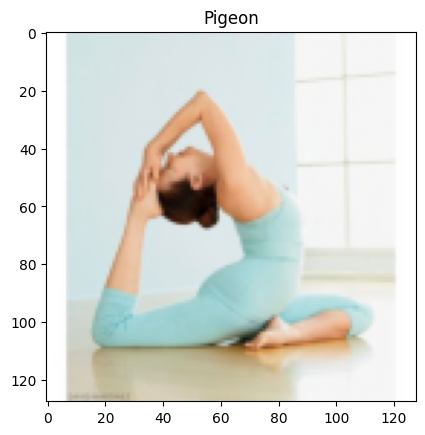

In [8]:
plt.imshow(X[201])
plt.title(labels[Y[201]])
plt.show()

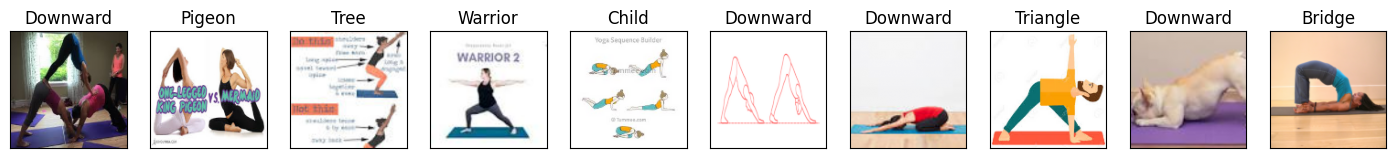

In [9]:
from random import randint
import matplotlib.pyplot as plt

n = 50  # how many digits we will display
plt.figure(figsize=(90,40))

for i in range(10,20):
    # display original
    rn = randint(0, len(X)-1)  # ensure rn is within the bounds of the array X
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X[rn])
    plt.title(labels[Y[rn]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
plt.close()


In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y)

print('Shapes of Data Split into Train & Test Part')
print(f'Training Data->{X_train.shape},{Y_train.shape} Testing Data->{X_test.shape,Y_test.shape}')

Shapes of Data Split into Train & Test Part
Training Data->(1714, 128, 128, 3),(1714,) Testing Data->((429, 128, 128, 3), (429,))


In [11]:
# OneHot-Encoding
from keras.utils import to_categorical

# Your code using to_categorical

Y_train=to_categorical(Y_train,num_classes=len(labels))
Y_test=to_categorical(Y_test,num_classes=len(labels))

Y_train.shape,Y_test.shape

((1714, 9), (429, 9))

In [12]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)

# Create a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam')




In [17]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32)

# Evaluate the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Loss: %.2f" % scores[0])
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/10
54/54 [==============================] - 503s 9s/step - loss: 0.1676 - accuracy: 0.9621 - val_loss: 0.6270 - val_accuracy: 0.8275
Epoch 2/10
54/54 [==============================] - 447s 8s/step - loss: 0.1379 - accuracy: 0.9638 - val_loss: 0.5971 - val_accuracy: 0.8555
Epoch 3/10
54/54 [==============================] - 492s 9s/step - loss: 0.1123 - accuracy: 0.9697 - val_loss: 0.5982 - val_accuracy: 0.8438
Epoch 4/10
54/54 [==============================] - 492s 9s/step - loss: 0.1129 - accuracy: 0.9691 - val_loss: 0.5535 - val_accuracy: 0.8788
Epoch 5/10
54/54 [==============================] - 497s 9s/step - loss: 0.1139 - accuracy: 0.9697 - val_loss: 0.6479 - val_accuracy: 0.8462
Epoch 6/10
54/54 [==============================] - 496s 9s/step - loss: 0.1158 - accuracy: 0.9702 - val_loss: 0.6209 - val_accuracy: 0.8322
Epoch 7/10
54/54 [==============================] - 498s 9s/step - loss: 0.1110 - accuracy: 0.9720 - val_loss: 0.5791 - val_accuracy: 0.8485
Epoch 8/10
54

Text(0.5, 1.0, 'Loss evolution')

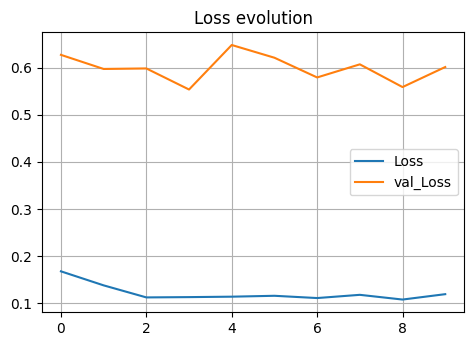

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

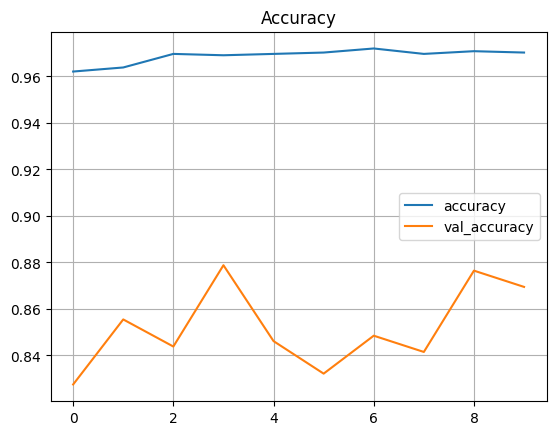

In [19]:
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [20]:
score=model.evaluate(X_test,Y_test,verbose=1)

14/14 [==============================] - 87s 6s/step - loss: 0.6012 - accuracy: 0.8695


In [21]:
Y_test=np.argmax(Y_test,axis=1)

In [22]:
print(Y_test)

[6 1 2 0 2 2 1 6 4 8 4 0 3 2 8 6 4 1 7 5 5 8 1 8 3 4 1 8 4 4 1 5 5 7 6 5 0
 8 6 4 7 2 6 2 7 7 3 5 4 4 7 1 5 1 2 8 1 5 6 1 7 0 7 4 7 0 2 4 1 4 8 2 5 2
 6 4 7 5 6 0 3 5 1 4 8 8 4 4 3 6 3 0 1 4 1 0 0 5 0 0 7 7 3 2 6 8 5 3 0 8 6
 2 4 2 8 6 3 0 7 5 4 4 8 4 1 3 8 3 4 6 0 6 4 6 1 3 8 6 8 1 4 2 2 8 4 1 2 1
 8 4 8 5 1 1 6 8 3 0 4 7 5 3 3 2 3 6 1 3 0 6 0 2 7 6 5 4 3 4 7 6 6 3 4 8 4
 3 3 3 2 1 8 1 2 4 3 8 1 1 0 7 4 8 7 3 5 3 1 0 8 3 1 6 0 0 4 7 2 8 3 2 0 1
 4 5 8 3 2 4 2 6 7 0 5 5 1 4 6 5 0 6 7 5 0 1 1 8 8 3 5 8 0 4 7 8 0 0 5 3 1
 1 4 2 3 8 3 8 3 7 3 8 0 6 6 3 2 7 3 6 2 8 4 1 7 7 1 4 8 2 6 2 5 4 0 0 6 4
 3 3 8 7 4 5 8 1 8 7 8 5 7 4 5 1 5 1 5 4 4 6 1 7 7 2 1 3 4 2 6 1 2 8 8 8 1
 2 8 3 2 0 8 7 4 4 7 3 2 5 6 0 7 1 1 3 4 5 5 0 1 2 1 1 2 0 3 6 0 6 0 3 0 5
 0 4 1 3 7 0 7 3 8 8 8 2 6 6 4 6 1 8 7 0 5 5 1 6 8 1 4 6 2 3 4 3 3 1 3 4 8
 4 5 2 5 6 5 3 7 1 4 0 8 8 4 3 5 6 6 5 4 7 1]


In [23]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print(y_pred)

14/14 [==============================] - 88s 6s/step
[6 1 2 7 4 2 1 6 4 8 4 0 3 2 8 6 4 1 7 5 5 8 4 8 3 4 1 8 4 4 1 5 3 2 6 5 0
 8 6 4 7 2 6 2 7 7 7 5 4 4 7 1 5 1 2 7 1 5 6 1 7 0 7 4 7 0 2 4 1 4 8 2 5 4
 6 4 7 5 2 0 3 5 7 4 8 8 4 4 3 2 3 0 4 4 7 0 0 5 0 0 7 0 3 2 6 8 5 3 4 8 5
 4 4 2 8 6 3 7 7 5 4 4 8 4 1 3 7 3 3 6 0 6 4 6 1 3 8 6 4 1 4 2 4 8 4 1 2 1
 8 4 8 5 1 1 6 8 3 0 4 7 5 3 3 4 3 6 1 3 0 6 0 2 7 6 5 4 3 4 7 6 6 0 4 8 4
 3 3 3 2 1 8 1 2 4 3 8 1 5 0 7 4 8 7 0 5 3 1 0 0 3 1 6 3 0 4 7 2 8 3 2 0 1
 4 5 8 3 2 4 2 6 7 0 5 5 1 4 6 5 7 6 7 5 0 1 4 8 8 3 5 8 0 4 7 8 7 7 7 3 1
 1 4 2 3 1 3 8 3 7 3 8 0 0 6 3 2 0 3 6 4 4 4 1 7 3 4 4 8 4 6 2 5 4 0 0 6 4
 3 3 8 7 4 5 8 1 8 7 8 5 7 4 5 1 5 1 5 4 4 6 1 7 7 2 1 3 7 2 6 1 2 8 8 8 1
 2 8 7 1 0 8 7 4 7 7 7 2 5 6 0 7 1 1 3 4 5 5 0 1 2 1 1 2 0 3 6 0 6 0 3 0 5
 0 0 1 3 0 4 7 3 8 8 0 4 6 7 4 6 1 8 7 0 5 5 1 6 8 4 4 6 2 3 4 3 3 5 3 4 8
 4 5 2 5 6 5 3 7 5 4 0 4 8 4 3 5 6 6 5 4 7 1]


In [24]:
from sklearn import metrics
print(metrics.confusion_matrix(Y_test,y_pred))

[[34  0  0  1  2  0  0  5  0]
 [ 0 45  0  0  5  3  0  2  0]
 [ 0  1 31  0  8  0  0  0  0]
 [ 2  0  0 47  0  0  0  3  0]
 [ 1  0  0  1 56  0  0  2  0]
 [ 0  0  0  1  0 40  0  1  0]
 [ 1  0  2  0  0  1 40  1  0]
 [ 3  0  1  1  0  0  0 34  0]
 [ 2  1  0  0  3  0  0  2 46]]


In [25]:
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        42
           1       0.96      0.82      0.88        55
           2       0.91      0.78      0.84        40
           3       0.92      0.90      0.91        52
           4       0.76      0.93      0.84        60
           5       0.91      0.95      0.93        42
           6       1.00      0.89      0.94        45
           7       0.68      0.87      0.76        39
           8       1.00      0.85      0.92        54

    accuracy                           0.87       429
   macro avg       0.88      0.87      0.87       429
weighted avg       0.88      0.87      0.87       429



14/14 [==============================] - 91s 6s/step


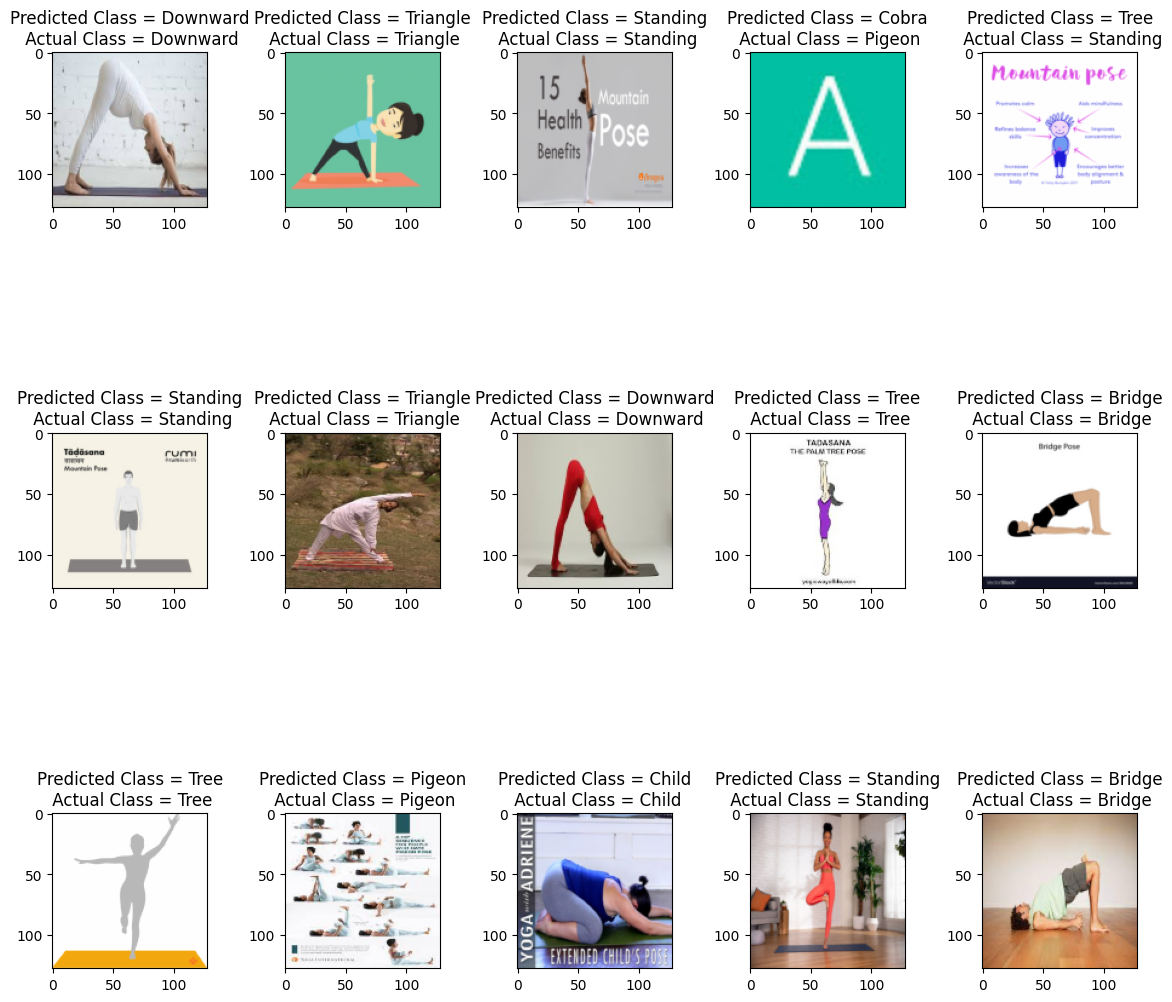

In [26]:
predicted_classes=model.predict(X_test)
predicted_classes=np.argmax(predicted_classes,1)
Y_classes=Y_test
L = 3
W = 5
fig, axes = plt.subplots(L, W, figsize = (14,14))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Predicted Class = {labels[predicted_classes[i]]}\n Actual Class = {labels[Y_classes[i]]}")
    axes[i].axis('on')
plt.subplots_adjust(wspace=0.5)